In [69]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from scipy.spatial.distance import cosine
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix, csc_matrix, lil_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Load Dataset:

In [2]:
item_df = pd.read_pickle("clean_df.pkl")
item_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244666 entries, 0 to 244665
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   user_id                 244666 non-null  object 
 1   business_id             244666 non-null  object 
 2   review_id               244666 non-null  object 
 3   name_business           244666 non-null  object 
 4   name_user               244666 non-null  object 
 5   review_count_business   244666 non-null  int64  
 6   review_count_user       244666 non-null  int64  
 7   average_stars_user      244666 non-null  float64
 8   average_stars_business  244666 non-null  float64
 9   stars_review            244666 non-null  float64
dtypes: float64(3), int64(2), object(5)
memory usage: 18.7+ MB


**Description of Dataset:**

Every record corresponds to a unique review.

* `review_id` unique value for each review
* `user_id` unique value for each user
* `business_id` unique value for each business
* `name_business` name of the business
* `name_user` name of the user
* `review_count_business` the number of reviews made for a business
* `review_count_user` the number of reviews made by a user
* `average_stars_user` the average star rating of each user
* `average_stars_business` the average star rating of the business
* `stars_review` the star rating of the specific review

### Will Only Look at Users with at least 10 Reviews in this recent New Orleans subset:

In [3]:
# Add the review count as a new column in avg_df
user_review_counts = item_df['user_id'].value_counts()
item_df['review_count_user_NO'] = item_df['user_id'].map(user_review_counts)

In [4]:
filtered_df = item_df[
        (item_df['review_count_user_NO'] >= 10)
    ].copy()

In [5]:
print("Total Number of Reviews", filtered_df.shape[0])
print("Users in this set", filtered_df['user_id'].unique().shape[0], "Restaurants", filtered_df['business_id'].unique().shape[0])
filtered_df.tail()

Total Number of Reviews 39713
Users in this set 2003 Restaurants 1707


,user_id,business_id,review_id,name_business,name_user,review_count_business,review_count_user,average_stars_user,average_stars_business,stars_review,review_count_user_NO
244650,zzawiLRYd4TjHKVyx6zjUQ,QE2KzOMx80dUIkW7NNiH6w,eEHdtNxv4lQ3XTLTtnmQnA,Coco Hut,Kierstin,76,58,2.46,4.5,5.0,12
244651,zzawiLRYd4TjHKVyx6zjUQ,RC5DvxYvcR_RXfefEHJIMQ,zybajkBc28-gJ34Vh5ybAA,Soul's Seafood Market,Kierstin,17,58,2.46,4.0,5.0,12
244652,zzawiLRYd4TjHKVyx6zjUQ,UGefDZNmnBztS0eoXWtHyQ,A_8K3RSt1b524Oy9GB__Kg,The Joint,Kierstin,1335,58,2.46,4.5,5.0,12
244653,zzawiLRYd4TjHKVyx6zjUQ,ac1AeYqs8Z4_e2X5M3if2A,5qsh2olWT1eR6DLe0d_Oaw,Oceana Grill,Kierstin,7400,58,2.46,4.0,5.0,12
244654,zzawiLRYd4TjHKVyx6zjUQ,kIMT0HWye1apfTH1-ITQAA,3VonlN8zj76PaG17dwB1TQ,Hanks Supermarket,Kierstin,79,58,2.46,3.5,3.0,12


**Heatmap of User-Restaurant Interactions:**

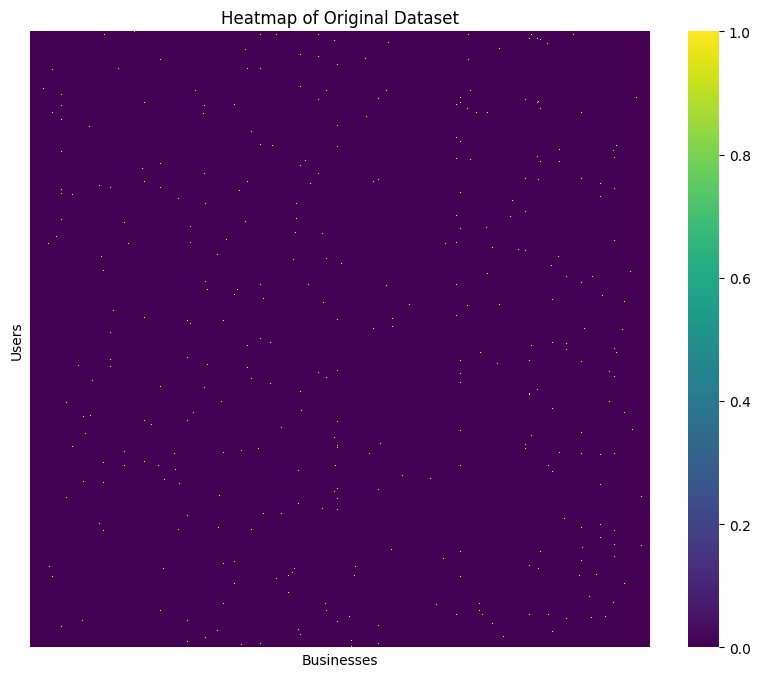

In [6]:
def create_sparse_matrix(df):
    """ Convert DataFrame into a sparse ratings matrix """
    df['user_id'] = df['user_id'].astype("category")
    df['business_id'] = df['business_id'].astype("category")
    
    row = df['user_id'].cat.codes
    col = df['business_id'].cat.codes
    data = df['stars_review'].values 
    sparse_matrix = csr_matrix((data, (row, col)), shape=(df['user_id'].cat.categories.size, df['business_id'].cat.categories.size))
    
    return sparse_matrix

def plot_heatmap(matrix, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, vmin=0, vmax=1, cmap='viridis', xticklabels=False, yticklabels=False)
    plt.title(title)
    plt.xlabel('Businesses')
    plt.ylabel('Users')
    plt.show()

sparse_matrix_original = create_sparse_matrix(item_df)
dense_matrix_original = sparse_matrix_original.toarray()
plot_heatmap(dense_matrix_original, 'Heatmap of Original Dataset')

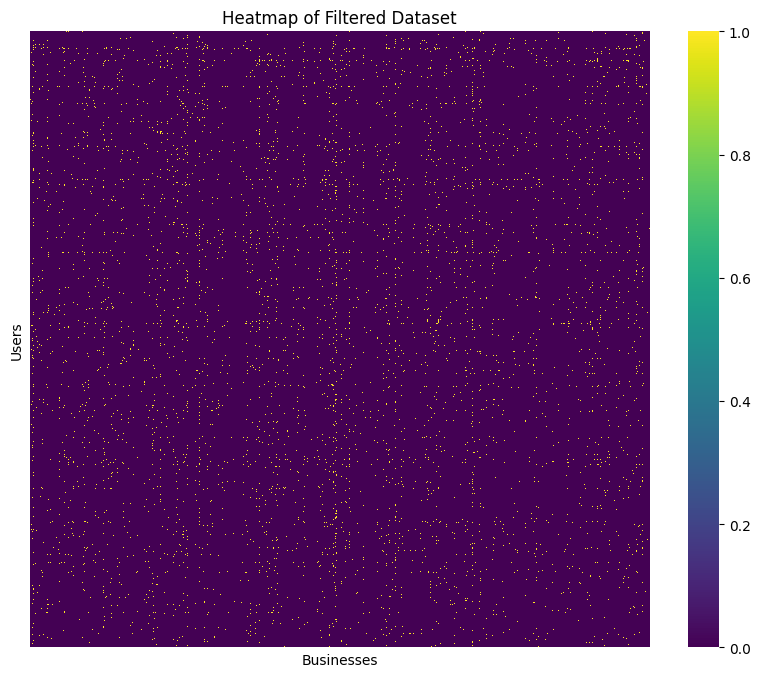

In [12]:
sparse_matrix_filtered = create_sparse_matrix(filtered_df)
dense_matrix_filtered = sparse_matrix_filtered.toarray()
plot_heatmap(dense_matrix_filtered, 'Heatmap of Filtered Dataset')

## Train-test Splits

In [12]:
def create_rating_matrix(dataframe, user_field='user_id', item_field='business_id', rate_field='stars_review'):
    """
    Construct a sparse matrix from rating data.
    """
    # Convert user and item IDs to categorical codes for matrix creation
    dataframe[user_field] = dataframe[user_field].astype("category")
    dataframe[item_field] = dataframe[item_field].astype("category")
    
    # Assign rows to users and columns to items with corresponding ratings
    user_indices = dataframe[user_field].cat.codes
    item_indices = dataframe[item_field].cat.codes
    ratings = dataframe[rate_field].values
    rating_matrix = csr_matrix((ratings, (user_indices, item_indices)), 
                               shape=(dataframe[user_field].cat.categories.size, dataframe[item_field].cat.categories.size))
    
    return rating_matrix, dataframe[user_field].cat.categories, dataframe[item_field].cat.categories

def split_rating_matrix(rating_matrix, val_reviews=2, test_reviews=2, seed=42):
    """
    Divide a ratings matrix into distinct training, validation, and testing sets.
    """
    np.random.seed(seed)  # For reproducibility
    
    num_users = rating_matrix.shape[0]
    rated_rows, rated_cols = rating_matrix.nonzero()

    # lil_matrix format for easier manipulation
    train_matrix = lil_matrix(rating_matrix.copy())
    test_matrix = lil_matrix(rating_matrix.shape)
    validation_matrix = lil_matrix(rating_matrix.shape)
    
    for user in range(num_users):
        # Identify all rated items by this user
        user_ratings = rated_cols[rated_rows == user]
        np.random.shuffle(user_ratings)  # Randomize item indices
        
        # Determine indices for test and validation sets
        test_indices = user_ratings[-test_reviews:]
        val_indices = user_ratings[-(test_reviews + val_reviews):-test_reviews]
        train_indices = user_ratings[:-(test_reviews + val_reviews)]
        
        # Populate the test and validation matrices
        test_matrix[user, test_indices] = rating_matrix[user, test_indices]
        validation_matrix[user, val_indices] = rating_matrix[user, val_indices]
        
        # Clear the selected test and validation ratings from the training matrix
        train_matrix[user, test_indices] = 0
        train_matrix[user, val_indices] = 0

    # Convert matrices back to csr format after assignment
    train_matrix = train_matrix.tocsr()
    test_matrix = test_matrix.tocsr()
    validation_matrix = validation_matrix.tocsr()

    # Ensure no overlap between training, validation, and test data
    assert (train_matrix.multiply(validation_matrix).nnz == 0)
    assert (train_matrix.multiply(test_matrix).nnz == 0)
    assert (validation_matrix.multiply(test_matrix).nnz == 0)
    
    return train_matrix, validation_matrix, test_matrix

rating_matrix, user_categories, item_categories = create_rating_matrix(filtered_df, user_field='user_id', item_field='business_id', rate_field='stars_review')
sparse_matrix_train, sparse_matrix_val, sparse_matrix_test = split_rating_matrix(rating_matrix, seed=42)

## Item-Based CF

### Adjusted Cosine Similarity:

**Adjusted Cosine Similarity:**

* Computing similarity using basic cosine measure in item-based case has one important drawback - the differences in rating scale between different users are not taken into account.
* Adjusted cosine similarity offsets this drawback by subtracting the corresponding user average from each co-rated pair
* Formally, the similarity between items i and j using this scheme is given by:

![](CorrBasedSim_algo.png)

* u)Here r-bar_u is the average of the u-th user's ratings.'s 

**Creating Similarity Matrix:**

To ensure no data leakage and only look at reviews relevant to this subset of the data, will ignore the precomputed average ratings and compute them from the subset manually.

In [111]:
def adjusted_cosine_similarity_matrix(train_matrix):
    '''Returns the adjusted cosine similarity between items'''

    # Calculate the mean rating for each user (row-wise mean)
    mean_user_rating = np.array(train_matrix.mean(axis=1)).reshape(-1, 1)
    
    # Subtract the mean user rating from each rating to get the difference matrix
    # This centers the ratings around zero, making the cosine similarity "adjusted"
    diff_matrix = train_matrix - mean_user_rating
    
    # Compute the raw similarity matrix by taking the dot product of the transposed
    # difference matrix with the difference matrix
    similarity = diff_matrix.T @ diff_matrix
    
    # Calculate the norm (magnitude) of each item's difference vector
    # Adding a small constant (1e-8) to avoid division by zero
    norm_array = np.sqrt(np.diag(similarity)) + 1e-8
    
    # Normalize the similarity matrix by dividing by the product of norms
    similarity = similarity / norm_array / norm_array.reshape(-1, 1)
    
    # Convert any NaN values to zero (in case of zero divisions)
    similarity = np.nan_to_num(similarity)
    
    return similarity

In [112]:
# Compute item-item adjusted cosine similarity matrix from the training set
cos_similarity_matrix = adjusted_cosine_similarity_matrix(sparse_matrix_train)
cos_similarity_matrix

matrix([[ 1.        , -0.01840716, -0.00505325, ..., -0.00480388,
         -0.00542907, -0.02205617],
        [-0.01840716,  1.        , -0.01637266, ..., -0.02906862,
         -0.01841082, -0.01951921],
        [-0.00505325, -0.01637266,  1.        , ...,  0.29317832,
          0.16147091,  0.00579407],
        ...,
        [-0.00480388, -0.02906862,  0.29317832, ...,  0.99999999,
          0.33491693,  0.01765792],
        [-0.00542907, -0.01841082,  0.16147091, ...,  0.33491693,
          1.        ,  0.00696321],
        [-0.02205617, -0.01951921,  0.00579407, ...,  0.01765792,
          0.00696321,  1.        ]])

**Functions to make ratings predictions:**

In [117]:
def predict_ratings_knn(ratings, similarity, k=10):
    # Convert to numpy arrays
    ratings = np.array(ratings)
    similarity = np.array(similarity)
    
    # Get the number of users and items
    n_users, n_items = ratings.shape
    
    # Initialize a prediction matrix with the same shape as the ratings matrix
    pred = np.zeros(ratings.shape)
    
    # Calculate the global average rating from the all the non-zero ratings
    global_avg = np.mean(ratings[ratings > 0])
    
    # Loop over each item to compute predictions
    for j in range(n_items):
        # Skip items that are out of bounds in the similarity matrix
        if j >= similarity.shape[0] or j >= similarity.shape[1]:
            continue
        
        # Set the similarity of the item with itself to negative infinity to exclude it from top-k items
        similarity[j, j] = -np.inf
        
        # Get the indices of the top-k similar items (excluding the item itself)
        top_k_items = np.argsort(similarity[:, j])[:-k-1:-1]
        # Ensure the indices are within the bounds of the number of items
        top_k_items = top_k_items[top_k_items < n_items]
        
        # Get the similarity weights for the top-k similar items
        weights = similarity[top_k_items, j]
        
        # If the sum of the absolute weights is non-zero, compute the prediction
        if np.sum(np.abs(weights)) != 0:
            # Extract the ratings for the top-k similar items
            sub_ratings = ratings[:, top_k_items]
            
            # Calculate the predicted rating as the global average plus the weighted sum of the top-k similar items' ratings
            pred[:, j] = global_avg + np.dot(sub_ratings, weights) / np.sum(np.abs(weights))
    
    # Return the prediction matrix
    return pred

**Testing Different K-values:**

In [118]:
def calculate_rmse(pred, actual):
    """
    Calculate the root mean square error between predicted and actual ratings.
    """
    if isinstance(actual, (csr_matrix, csc_matrix)):
        actual = actual.toarray()

    mask = actual != 0
    pred = np.asarray(pred)[mask].flatten()
    actual = np.asarray(actual)[mask].flatten()
    rmse = np.sqrt(mean_squared_error(actual, pred))
    return rmse

def test_k_values(train_matrix, val_matrix, similarity_matrix, max_k=40):
    """
    Test various k values for prediction and plot the RMSE for each k.
    """
    train_errors = []
    val_errors = []
    k_values = range(1, max_k + 1, 2)

    if isinstance(train_matrix, (csr_matrix, csc_matrix)):
        train_matrix = train_matrix.toarray()
    if isinstance(val_matrix, (csr_matrix, csc_matrix)):
        val_matrix = val_matrix.toarray()

    for k in k_values:
        preds_train = predict_ratings_knn(train_matrix, similarity_matrix, k=k)
        if preds_train.shape != train_matrix.shape:
            raise ValueError(f"Shape mismatch: {preds_train.shape} predictions vs {train_matrix.shape} train matrix.")
        rmse_train = calculate_rmse(preds_train, train_matrix)
        train_errors.append(rmse_train)
        
        preds_val = predict_ratings_knn(val_matrix, similarity_matrix, k=k)
        if preds_val.shape != val_matrix.shape:
            raise ValueError(f"Shape mismatch: {preds_val.shape} predictions vs {val_matrix.shape} val matrix.")
        rmse_val = calculate_rmse(preds_val, val_matrix)
        val_errors.append(rmse_val)

        print(f"k={k}: Train RMSE={rmse_train}, Validation RMSE={rmse_val}")

    best_k_train = k_values[np.argmin(train_errors)]
    best_rmse_train = min(train_errors)
    best_k_val = k_values[np.argmin(val_errors)]
    best_rmse_val = min(val_errors)
    
    print(f"Best k for Train RMSE: k={best_k_train}, RMSE={best_rmse_train}")
    print(f"Best k for Validation RMSE: k={best_k_val}, RMSE={best_rmse_val}")

    plt.figure(figsize=(10, 6))
    plt.plot(k_values, train_errors, marker='o', linestyle='-', color='b', label='Train RMSE')
    plt.plot(k_values, val_errors, marker='o', linestyle='-', color='r', label='Validation RMSE')
    plt.title('RMSE vs. Number of Neighbors (k)')
    plt.xlabel('k (Number of Neighbors)')
    plt.ylabel('Root Mean Square Error (RMSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

Testing item-based similarity...
k=1: Train RMSE=1.9036153482405638, Validation RMSE=1.1662165781857363
k=3: Train RMSE=1.472625228225725, Validation RMSE=1.1350896806096937
k=5: Train RMSE=1.3551579240694074, Validation RMSE=1.129080933848764
k=7: Train RMSE=1.299124684837375, Validation RMSE=1.1271421661811831
k=9: Train RMSE=1.26816643579968, Validation RMSE=1.1265511450776515
k=11: Train RMSE=1.244050833643705, Validation RMSE=1.1262755026157483
k=13: Train RMSE=1.2276065274167771, Validation RMSE=1.125918733483538
k=15: Train RMSE=1.2141814323887727, Validation RMSE=1.1258047765944734
k=17: Train RMSE=1.2032589870020425, Validation RMSE=1.1257804570981422
k=19: Train RMSE=1.1945925910829274, Validation RMSE=1.1254900404548083
k=21: Train RMSE=1.1867910017757504, Validation RMSE=1.1253454872356434
k=23: Train RMSE=1.180723941972937, Validation RMSE=1.1253943500276975
k=25: Train RMSE=1.1751181835564553, Validation RMSE=1.12545487951311
k=27: Train RMSE=1.16945000414413, Validation 

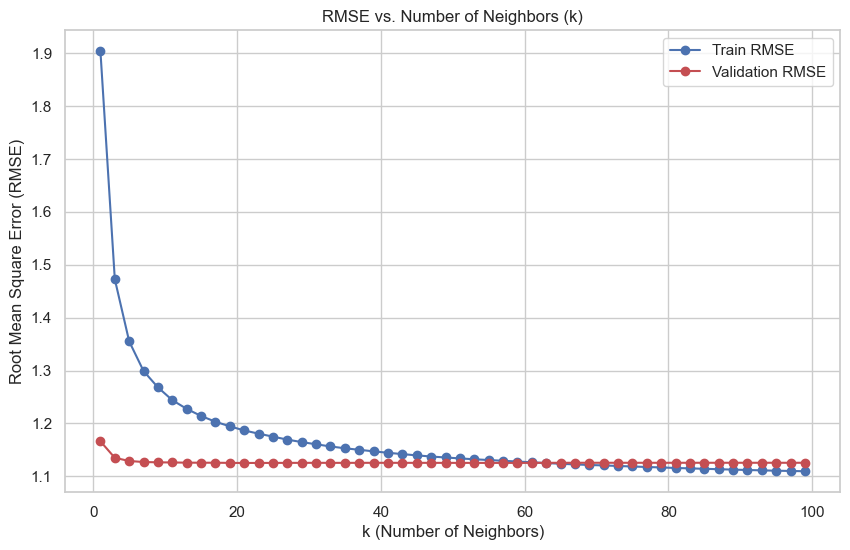

In [119]:
# Convert sparse matrices to dense for prediction
dense_matrix_train = sparse_matrix_train.todense()
dense_matrix_val = sparse_matrix_val.todense()

# Test with item-based similarity
print("Testing item-based similarity...")
test_k_values(dense_matrix_train, dense_matrix_val, cos_similarity_matrix, max_k=100)

### Pearson Correlation:

In [48]:
def pearson_correlation_similarity_matrix(train_matrix):
    '''Returns the Pearson correlation similarity between items'''

    # Calculate the mean rating for each item (column-wise mean)
    mean_item_rating = np.array(train_matrix.mean(axis=0)).flatten()
    
    # Subtract the mean item rating from each rating to get the difference matrix
    # This centers the ratings around zero, making the correlation "Pearson"
    diff_matrix = train_matrix - mean_item_rating
    
    # Compute the raw similarity matrix by taking the dot product of the transposed
    # difference matrix with the difference matrix
    similarity = diff_matrix.T @ diff_matrix
    
    # Calculate the norm (magnitude) of each item's difference vector
    # Adding a small constant (1e-8) to avoid division by zero
    norm_array = np.sqrt(np.diag(similarity)) + 1e-8
    
    # Normalize the similarity matrix by dividing by the product of norms
    similarity = similarity / norm_array / norm_array.reshape(-1, 1)
    
    # Convert any NaN values to zero (in case of zero divisions)
    similarity = np.nan_to_num(similarity)
    
    return similarity

In [49]:
# Compute item-item adjusted cosine similarity matrix from the training set
pearson_similarity_matrix = pearson_correlation_similarity_matrix(sparse_matrix_train)
pearson_similarity_matrix

matrix([[ 9.99999999e-01, -1.23864964e-02, -2.79600954e-03, ...,
         -2.03747549e-03, -2.85314985e-03, -6.11200389e-03],
        [-1.23864964e-02,  9.99999999e-01, -4.16714168e-03, ...,
         -3.03663093e-03, -4.25230297e-03, -9.10926298e-03],
        [-2.79600954e-03, -4.16714168e-03,  9.99999997e-01, ...,
         -6.85460097e-04, -9.59874306e-04, -2.05623812e-03],
        ...,
        [-2.03747549e-03, -3.03663093e-03, -6.85460097e-04, ...,
          9.99999990e-01, -6.99468419e-04, -1.49839789e-03],
        [-2.85314985e-03, -4.25230297e-03, -9.59874306e-04, ...,
         -6.99468419e-04,  9.99999996e-01, -2.09826019e-03],
        [-6.11200389e-03, -9.10926298e-03, -2.05623812e-03, ...,
         -1.49839789e-03, -2.09826019e-03,  9.99999999e-01]])

k=1: Train RMSE=1.7373655897716593, Validation RMSE=1.1882064344620282
k=3: Train RMSE=1.38922763614816, Validation RMSE=1.170165056459819
k=5: Train RMSE=1.3140029912894926, Validation RMSE=1.1670753773669842
k=7: Train RMSE=1.2817468692845824, Validation RMSE=1.1659463470605418
k=9: Train RMSE=1.2645582559290232, Validation RMSE=1.1660908414305027
k=11: Train RMSE=1.2541937653939144, Validation RMSE=1.165660665543215
k=13: Train RMSE=1.2471478285993531, Validation RMSE=1.1652906095656221
k=15: Train RMSE=1.2420864919548584, Validation RMSE=1.1650116918406825
k=17: Train RMSE=1.2387727267492321, Validation RMSE=1.1647827284563397
k=19: Train RMSE=1.2363402318462875, Validation RMSE=1.164689736372729
k=21: Train RMSE=1.2337804127419598, Validation RMSE=1.164693247161904
k=23: Train RMSE=1.231741309518838, Validation RMSE=1.1646994529408583
k=25: Train RMSE=1.2295473670787842, Validation RMSE=1.1647926387200072
k=27: Train RMSE=1.2278779330895064, Validation RMSE=1.164760751333141
k=29:

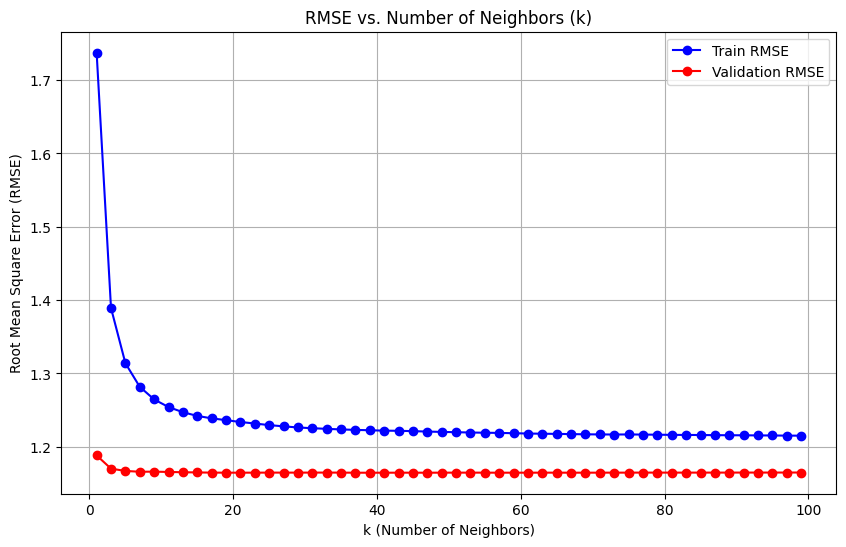

In [50]:
test_k_values(dense_matrix_train, dense_matrix_val, pearson_similarity_matrix, max_k=100)

## User-Based CF

**Adjusted Cosine:**

In [52]:
def adjusted_cosine_similarity_matrix_users(train_matrix):
    '''Returns the adjusted cosine similarity between users'''
    
    # Convert the train_matrix to a dense array if it is sparse
    if isinstance(train_matrix, csr_matrix):
        train_matrix = train_matrix.toarray()

    # Calculate the mean rating for each item (column-wise mean)
    mean_item_rating = np.array(train_matrix.mean(axis=0)).flatten()
    
    # Subtract the mean item rating from each rating to get the difference matrix
    # This centers the ratings around zero, making the cosine similarity "adjusted"
    diff_matrix = train_matrix - mean_item_rating
    
    # Compute the raw similarity matrix by taking the dot product of the transposed
    # difference matrix with the difference matrix
    similarity = diff_matrix @ diff_matrix.T
    
    # Calculate the norm (magnitude) of each user's difference vector
    # Adding a small constant (1e-8) to avoid division by zero
    norm_array = np.sqrt(np.diag(similarity)) + 1e-8
    
    # Normalize the similarity matrix by dividing by the product of norms
    similarity = similarity / norm_array / norm_array.reshape(-1, 1)
    
    # Convert any NaN values to zero (in case of zero divisions)
    similarity = np.nan_to_num(similarity)
    
    return similarity

In [56]:
# Compute item-item adjusted cosine similarity matrix from the training set
acos_similarity_matrix_users = adjusted_cosine_similarity_matrix_users(sparse_matrix_train)
acos_similarity_matrix_users

array([[ 9.99999999e-01,  1.03725467e-01,  8.20022673e-02, ...,
         8.16424205e-03,  2.04219215e-01, -2.76732412e-03],
       [ 1.03725467e-01,  9.99999998e-01, -1.97109339e-02, ...,
         3.50149314e-02,  6.08891443e-02,  5.50047125e-03],
       [ 8.20022673e-02, -1.97109339e-02,  9.99999999e-01, ...,
        -4.22687958e-02,  3.93191187e-02,  9.91153836e-04],
       ...,
       [ 8.16424205e-03,  3.50149314e-02, -4.22687958e-02, ...,
         9.99999999e-01,  1.72737904e-02, -3.94534807e-02],
       [ 2.04219215e-01,  6.08891443e-02,  3.93191187e-02, ...,
         1.72737904e-02,  9.99999999e-01,  1.64908243e-01],
       [-2.76732412e-03,  5.50047125e-03,  9.91153836e-04, ...,
        -3.94534807e-02,  1.64908243e-01,  9.99999998e-01]])

In [57]:
def predict_ratings_knn_users(ratings, similarity, k=10):
    # Convert ratings and similarity matrices to numpy arrays for easier manipulation
    ratings = np.array(ratings)
    similarity = np.array(similarity)
    
    # Get the number of users and items from the shape of the ratings matrix
    n_users, n_items = ratings.shape
    
    # Initialize a prediction matrix with the same shape as the ratings matrix, filled with zeros
    pred = np.zeros(ratings.shape)
    
    # Calculate the global average rating from the ratings matrix (considering only non-zero ratings)
    global_avg = np.mean(ratings[ratings > 0])
    
    # Loop over each user to compute predictions
    for i in range(n_users):
        if i >= similarity.shape[0] or i >= similarity.shape[1]:
            continue
        
        # Set the similarity of the user with themselves to negative infinity to exclude them from top-k users
        similarity[i, i] = -np.inf
        
        # Get the indices of the top-k similar users (excluding the user themselves)
        top_k_users = np.argsort(similarity[i, :])[:-k-1:-1]
        top_k_users = top_k_users[top_k_users < n_users]
        
        # Get the similarity weights for the top-k similar users
        weights = similarity[i, top_k_users]
        
        # If the sum of the absolute weights is non-zero, compute the prediction
        if np.sum(np.abs(weights)) != 0:
            for j in range(n_items):
                sub_ratings = ratings[top_k_users, j]
                pred[i, j] = global_avg + np.dot(sub_ratings, weights) / np.sum(np.abs(weights))
    
    # Return the prediction matrix
    return pred

In [58]:
def test_k_values_users(train_matrix, val_matrix, similarity_matrix, max_k=40):
    """
    Test various k values for user-based prediction and plot the RMSE for each k.
    """
    train_errors = []
    val_errors = []
    k_values = range(1, max_k + 1, 2)

    if isinstance(train_matrix, (csr_matrix, csc_matrix)):
        train_matrix = train_matrix.toarray()
    if isinstance(val_matrix, (csr_matrix, csc_matrix)):
        val_matrix = val_matrix.toarray()

    for k in k_values:
        preds_train = predict_ratings_knn_users(train_matrix, similarity_matrix, k=k)
        if preds_train.shape != train_matrix.shape:
            raise ValueError(f"Shape mismatch: {preds_train.shape} predictions vs {train_matrix.shape} train matrix.")
        rmse_train = calculate_rmse(preds_train, train_matrix)
        train_errors.append(rmse_train)
        
        preds_val = predict_ratings_knn_users(val_matrix, similarity_matrix, k=k)
        if preds_val.shape != val_matrix.shape:
            raise ValueError(f"Shape mismatch: {preds_val.shape} predictions vs {val_matrix.shape} val matrix.")
        rmse_val = calculate_rmse(preds_val, val_matrix)
        val_errors.append(rmse_val)

        print(f"k={k}: Train RMSE={rmse_train}, Validation RMSE={rmse_val}")

    best_k_train = k_values[np.argmin(train_errors)]
    best_rmse_train = min(train_errors)
    best_k_val = k_values[np.argmin(val_errors)]
    best_rmse_val = min(val_errors)
    
    print(f"Best k for Train RMSE: k={best_k_train}, RMSE={best_rmse_train}")
    print(f"Best k for Validation RMSE: k={best_k_val}, RMSE={best_rmse_val}")

    plt.figure(figsize=(10, 6))
    plt.plot(k_values, train_errors, marker='o', linestyle='-', color='b', label='Train RMSE')
    plt.plot(k_values, val_errors, marker='o', linestyle='-', color='r', label='Validation RMSE')
    plt.title('RMSE vs. Number of Neighbors (k)')
    plt.xlabel('k (Number of Neighbors)')
    plt.ylabel('Root Mean Square Error (RMSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

Testing item-based similarity...
k=1: Train RMSE=2.190775687866761, Validation RMSE=1.2152798246022003
k=3: Train RMSE=1.6680768314196517, Validation RMSE=1.1564007928277102
k=5: Train RMSE=1.5255341224305898, Validation RMSE=1.1431794179939248
k=7: Train RMSE=1.4553097617823603, Validation RMSE=1.1351452135921156
k=9: Train RMSE=1.4131199742005571, Validation RMSE=1.1326347174104103
k=11: Train RMSE=1.3831186938336886, Validation RMSE=1.130322047485204
k=13: Train RMSE=1.3600974113007231, Validation RMSE=1.1294673397321269
k=15: Train RMSE=1.34165835747052, Validation RMSE=1.1290097585722345
k=17: Train RMSE=1.3260596702001213, Validation RMSE=1.1281473493491132
k=19: Train RMSE=1.3126858865640676, Validation RMSE=1.1279225557184263
k=21: Train RMSE=1.302694147919794, Validation RMSE=1.1281303838529118
k=23: Train RMSE=1.2926259486109357, Validation RMSE=1.1280155658821822
k=25: Train RMSE=1.2842239023529376, Validation RMSE=1.1276976605615279
k=27: Train RMSE=1.2760697973584092, Vali

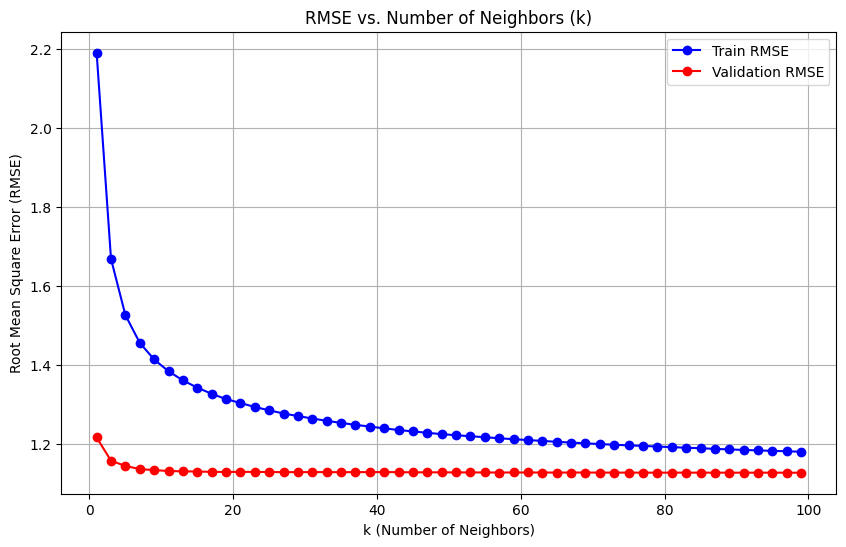

In [59]:
# Convert sparse matrices to dense for prediction
dense_matrix_train = sparse_matrix_train.todense()
dense_matrix_val = sparse_matrix_val.todense()

# Test with item-based similarity
print("Testing user-based similarity...")
test_k_values_users(dense_matrix_train, dense_matrix_val, acos_similarity_matrix_users, max_k=100)

**Pearson Correlation:**

In [60]:
def pearson_correlation_similarity_matrix_users(train_matrix):
    '''Returns the Pearson correlation similarity between users'''
    
    # Convert the train_matrix to a dense array if it is sparse
    if isinstance(train_matrix, csr_matrix):
        train_matrix = train_matrix.toarray()

    # Calculate the mean rating for each user (row-wise mean)
    mean_user_rating = np.array(train_matrix.mean(axis=1)).reshape(-1, 1)
    
    # Subtract the mean user rating from each rating to get the difference matrix
    # This centers the ratings around zero, making the correlation "Pearson"
    diff_matrix = train_matrix - mean_user_rating
    
    # Compute the raw similarity matrix by taking the dot product of the transposed
    # difference matrix with the difference matrix
    similarity = diff_matrix @ diff_matrix.T
    
    # Calculate the norm (magnitude) of each user's difference vector
    # Adding a small constant (1e-8) to avoid division by zero
    norm_array = np.sqrt(np.diag(similarity)) + 1e-8
    
    # Normalize the similarity matrix by dividing by the product of norms
    similarity = similarity / norm_array / norm_array.reshape(-1, 1)
    
    # Convert any NaN values to zero (in case of zero divisions)
    similarity = np.nan_to_num(similarity)
    
    return similarity

In [61]:
# Compute item-item adjusted cosine similarity matrix from the training set
pearson_similarity_matrix_users = pearson_correlation_similarity_matrix_users(sparse_matrix_train)
pearson_similarity_matrix_users

array([[ 1.        ,  0.11475259,  0.09059269, ...,  0.02520634,
         0.21212298, -0.00605167],
       [ 0.11475259,  1.        , -0.00432987, ...,  0.07497409,
         0.08362548, -0.00362926],
       [ 0.09059269, -0.00432987,  1.        , ..., -0.01148762,
         0.05646661, -0.00458378],
       ...,
       [ 0.02520634,  0.07497409, -0.01148762, ...,  1.        ,
         0.03166669, -0.00962883],
       [ 0.21212298,  0.08362548,  0.05646661, ...,  0.03166669,
         1.        ,  0.17779465],
       [-0.00605167, -0.00362926, -0.00458378, ..., -0.00962883,
         0.17779465,  1.        ]])

Testing user-based similarity...
k=1: Train RMSE=2.148276431377334, Validation RMSE=1.2232517717721325
k=3: Train RMSE=1.6416919839275947, Validation RMSE=1.155828730718061
k=5: Train RMSE=1.5128308540227302, Validation RMSE=1.1416566053728594
k=7: Train RMSE=1.4506125818095053, Validation RMSE=1.136646884936284
k=9: Train RMSE=1.4077251871003011, Validation RMSE=1.1335096580797552
k=11: Train RMSE=1.379418044735922, Validation RMSE=1.1312386310972533
k=13: Train RMSE=1.3572851634348067, Validation RMSE=1.1300071956402828
k=15: Train RMSE=1.3409674822286142, Validation RMSE=1.12908016890942
k=17: Train RMSE=1.326422299520373, Validation RMSE=1.1282046349254904
k=19: Train RMSE=1.3142178555409165, Validation RMSE=1.127727701835235
k=21: Train RMSE=1.3040082179807386, Validation RMSE=1.1278293271652757
k=23: Train RMSE=1.2958474722022653, Validation RMSE=1.1278594739564547
k=25: Train RMSE=1.2879966409279853, Validation RMSE=1.1274304721953283
k=27: Train RMSE=1.2812101503212094, Validat

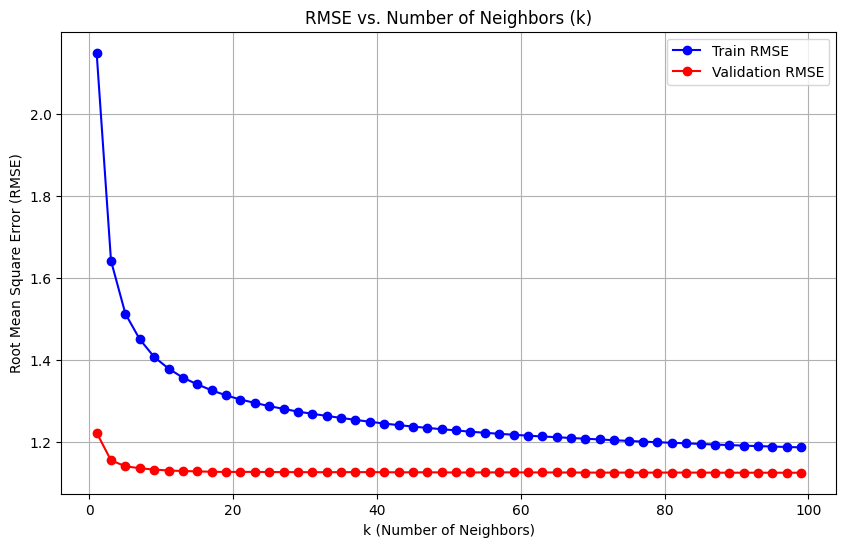

In [63]:
# Test with item-based similarity
print("Testing user-based similarity...")
test_k_values_users(dense_matrix_train, dense_matrix_val, pearson_similarity_matrix_users, max_k=100)

**Best Model:**

The best model seems to be the Item-Based CF with adjusted cosine similarity, as it achieves the lowest train rmse with very high k-values, and the best validation rmse at k=21.4

## Performance of Best Model and k-value on Test Set:

In [66]:
def calculate_performance_metrics(pred, actual):
    """
    Calculate RMSE, MAE, and R2 between predicted and actual ratings.
    """
    mask = actual != 0
    pred = np.asarray(pred)[mask].flatten()
    actual = np.asarray(actual)[mask].flatten()
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)

    return rmse, mae, r2

In [120]:
dense_matrix_test = sparse_matrix_test.todense()
preds_test = predict_ratings_knn(dense_matrix_test, cos_similarity_matrix, k=21)

# Calculate RMSE, MAE, and R2
rmse_test, mae_test, r2_test = calculate_performance_metrics(preds_test, dense_matrix_test)

print("Test RMSE:", rmse_test)
print("Test MAE:", mae_test)
print("Test R^2:", r2_test)

Test RMSE: 1.1036802182997867
Test MAE: 0.8552001949635221
Test R^2: 0.0006609997618344243


## Creating Recommendations

Will use the best method from above (item-based cf with adjusted cosine similarity) to recommend the restaurants with the highest predicted ratings for a given user.

In [129]:
def usernamefromid(df, user_id):
    if user_id in df['user_id'].values:
        return df[df.user_id == user_id]['name_user'].iloc[0]
    else:
        return "Unknown User"

def biznamefromid(df, business_id):
    if business_id in df['business_id'].values:
        return df[df.business_id == business_id]['name_business'].iloc[0]

def get_top_n_recommendations(df, user_id, user_categories, item_categories, ratings_matrix, similarity_matrix, k=40, N=5):
    """
    Get the top N business recommendations for a given user.
    """
    # Get the index of the user in the ratings matrix
    user_idx = user_categories.get_loc(user_id)
    
    # Predict ratings for all users or items
    pred_ratings = predict_ratings_knn(ratings_matrix, similarity_matrix, k=k)

    # Get the predicted ratings for the given user
    user_pred_ratings = pred_ratings[user_idx, :]

    # Find businesses that the user has not rated yet
    user_actual_ratings = np.asarray(ratings_matrix[user_idx, :]).flatten()
    unrated_indices = np.where(user_actual_ratings == 0)[0]

    # Get the predicted ratings for unrated businesses
    unrated_predictions = user_pred_ratings[unrated_indices]
    
    # Get the indices of the top N recommendations
    top_n_indices = np.argsort(unrated_predictions)[-N:][::-1]
    
    # Map back to business IDs
    top_n_business_ids = item_categories[unrated_indices[top_n_indices]]
    top_n_ratings = unrated_predictions[top_n_indices]

    # Map business IDs to business names
    top_n_business_names = [biznamefromid(df, biz_id) for biz_id in top_n_business_ids]

    # Create a DataFrame to return
    top_n_recommendations = pd.DataFrame({
        'business_id': top_n_business_ids,
        'restaurant_name': top_n_business_names,
        'predicted_rating': top_n_ratings
    })

    # Print the top recommendations for the user
    user_name = usernamefromid(df, user_id)
    print(f"Top Recommendations for {user_name}:")

    return top_n_recommendations

In [130]:
# Convert sparse matrices to dense for prediction
dense_matrix_train = sparse_matrix_train.todense()
dense_matrix_val = sparse_matrix_val.todense()

# Get the top N recommendations for a given user
user_id = 'zLWaI3RP0IFCwMAERFRR0Q' 
top_n_recommendations = get_top_n_recommendations(filtered_df, user_id, user_categories, item_categories, dense_matrix_train, cos_similarity_matrix, k=21, N=10)

print(top_n_recommendations)

Top Recommendations for Rowan:
              business_id              restaurant_name  predicted_rating
0  KLLO4MTEI2mDwdakz51www  Picnic Provisions & Whiskey          6.044256
1  tWoJMHMU-KUEeOFAcpENdg                  Union Ramen          6.019849
2  MyFC2F-5SXwXTLR99UWiqA                  The Vintage          5.914930
3  wtwDcp79klLOLaIjCFHQCA                 Saffron nola          5.880286
4  75FY8ZQx5nOWP0VFmNvWfw       Atchafalaya Restaurant          5.777536
5  I0I2mkCOPTYVSLpc8A8VVw                Compère Lapin          5.710457
6  EmJF-xSIOaEEOWcK8UOBqg                Fharmacy Nola          5.655875
7  3rRESenaBw-AyT0Jt7eJNg         Junior's on Harrison          5.649365
8  5xRmemqmR89BpGoOA25hqA                     Dian Xin          5.633330
9  hfbZ97Te3T4jeWN6GgsGrQ                   Willa Jean          5.599681
